In [1]:
import pyspark as ps
spark = ps.sql.SparkSession.builder.master("local").appName("ElbowMethodTest").getOrCreate()

In [2]:
df = spark.read.csv("filtered_clean.csv", header=True, inferSchema=True)
df.show(5)

+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+-------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+----------------+--------------------+-------------+--------------------+-------------+--------------+--------------+--------------+
|app_id|                name|type|required_age|is_free| supported_languages|          developers|          publishers|price_final|platforms_windows|platforms_mac|platforms_linux|          categories|              genres|recommendations_total|release_date|price_currency|

In [3]:
from pyspark.sql.functions import regexp_replace, when, col, array_contains, split, explode

In [4]:
# Step 1: Create a temporary column for cleaned categories
df = df.withColumn("categories_clean", regexp_replace("categories", "\\[|\\]|'", ""))
df = df.withColumn("categories_list", split(col("categories_clean"), ", "))

# Step 2: Explode categories
exploded = df.select("app_id", explode(col("categories_list")).alias("category"))

# Step 3: Get distinct categories and clean them
distinct_categories = (
    exploded.select("category")
    .distinct()
    .toPandas()["category"]
    .str.replace(" ", "_")
    .tolist()
)

# Step 4: Create binary columns with cat_ prefix
for cat in distinct_categories:
    df = df.withColumn(f"category_{cat}", when(array_contains(col("categories_list"), cat), 1).otherwise(0))

# Step 5: Drop temporary columns
df = df.drop("categories_clean", "categories_list", "category__Swahili", "category_False", "category__Latvian", "category__Maltese", "category__Luxembourgish","")

df.show()

+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+--------------+-----------

In [5]:
# Step 1: Create temporary columns for cleaned genres
df = df.withColumn("genres_clean", regexp_replace("genres", "\\[|\\]|'", ""))
df = df.withColumn("genres_list", split(col("genres_clean"), ", "))

# Step 2: Explode genres
exploded_genres = df.select("app_id", explode(col("genres_list")).alias("genre"))

# Step 3: Get distinct genres and clean them
distinct_genres = (
    exploded_genres.select("genre")
    .distinct()
    .toPandas()["genre"]
    .str.replace(" ", "_")
    .tolist()
)

# Step 4: Create binary columns with genre_ prefix
for genre in distinct_genres:
    df = df.withColumn(f"genre_{genre}", when(array_contains(col("genres_list"), genre), 1).otherwise(0))

# Step 5: Drop temporary columns
df = df.drop("genres_clean", "genres_list", "genre_Maori", "genre_false", "genre__Macedonian", "genre__Serbian", "genre_", "genre__Lithuanian")

df.show()

+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+--------------+-----------

In [6]:
# Convert 'is_free' to 0 and 1
df = df.withColumn("is_free", when(col("is_free") == True, 1).otherwise(0))

# Cast 'required_age' to integer
df = df.withColumn("required_age", col("required_age").cast("int"))

df.show()

+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+--------------+-----------

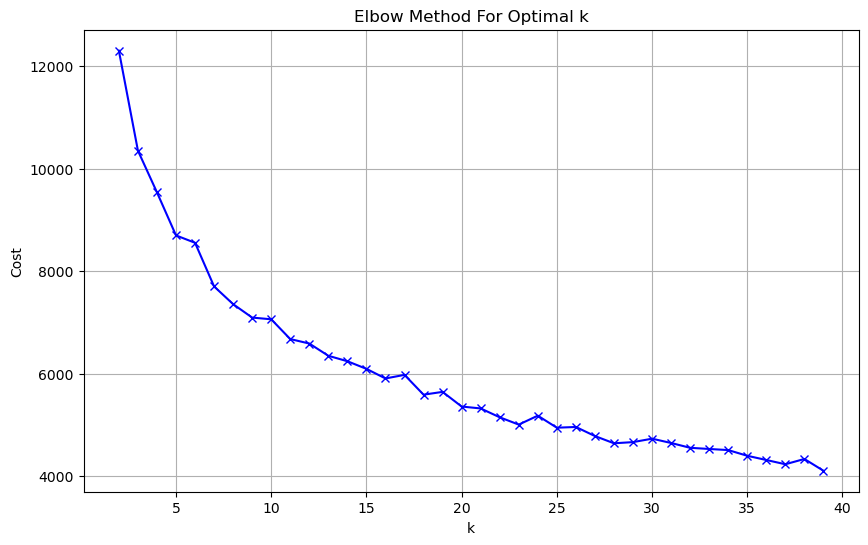

k: 2, Cost: 12297.872871418638
k: 3, Cost: 10349.90502854222
k: 4, Cost: 9536.202295070574
k: 5, Cost: 8696.578669893095
k: 6, Cost: 8552.728259831312
k: 7, Cost: 7701.3433477344715
k: 8, Cost: 7356.04210845409
k: 9, Cost: 7094.324175087008
k: 10, Cost: 7061.236879030092
k: 11, Cost: 6675.538751187197
k: 12, Cost: 6588.2622316766465
k: 13, Cost: 6349.5670673198965
k: 14, Cost: 6243.21928803473
k: 15, Cost: 6094.733323889137
k: 16, Cost: 5907.233230234217
k: 17, Cost: 5977.385014578705
k: 18, Cost: 5590.958688834939
k: 19, Cost: 5645.62387919054
k: 20, Cost: 5359.856791751251
k: 21, Cost: 5322.7234996385505
k: 22, Cost: 5150.032209102513
k: 23, Cost: 5007.471939367754
k: 24, Cost: 5181.591685680289
k: 25, Cost: 4947.211242494794
k: 26, Cost: 4961.167438945495
k: 27, Cost: 4784.478354006831
k: 28, Cost: 4643.213003200552
k: 29, Cost: 4666.113574681934
k: 30, Cost: 4732.798919080918
k: 31, Cost: 4649.216645240652
k: 32, Cost: 4555.050004910742
k: 33, Cost: 4532.440148881304
k: 34, Cost: 4

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create list of input columns
category_cols = [col for col in df.columns if col.startswith('category_')]
genre_cols = [col for col in df.columns if col.startswith('genre_')]
feature_cols = ['required_age', 'is_free'] + category_cols + genre_cols

# Fill null values with 0
df_clean = df.fillna(0, subset=feature_cols)

# Create VectorAssembler with handleInvalid="skip"
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"  # Skip invalid entries
)

# Transform the data
vector_df = assembler.transform(df_clean)

# Calculate cost for different k values
cost = []
K = range(2, 40)  # Test k from 2 to 20

for k in K:
    kmeans = KMeans(k=k, seed=42)
    model = kmeans.fit(vector_df.select('features'))
    cost.append(model.summary.trainingCost)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Print the costs
for k, c in zip(K, cost):
    print(f'k: {k}, Cost: {c}')

In [8]:
# Once you've chosen the optimal k, train the final model
optimal_k = 11  # Replace with your chosen optimal k
final_kmeans = KMeans(k=optimal_k, seed=42)
final_model = final_kmeans.fit(vector_df)

# Get cluster assignments
predictions = final_model.transform(vector_df)

# Evaluate the clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Get cluster centers
centers = final_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.25193695581987974
Cluster Centers: 
[0.         0.00923077 0.         0.         0.         0.
 0.         0.         0.         0.07230769 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.03384615 0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.01846154 0.         0.
 0.         0.         0.         0.00307692 0.         0.
 0.         0.         0.         0.         0.         0.22769231
 0.02769231 0.         0.         0.         0.02461538 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.24153846
 0.27076923 0.84       0.22       0.58923077]
[1.70357143e+01 5.10204082e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.55102041e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000

In [11]:
from pyspark.sql.functions import collect_list
# Group data points by their cluster assignment and show all data points for each cluster
predictions.groupBy('prediction').agg(collect_list('features')).show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------